Скачиваем Dry Bean (~4.5 МБ)...
Размер данных: (13611, 17)
Число компонент по 'локтю': 3

Accuracy: 0.8807

Classification report:
               precision    recall  f1-score   support

    BARBUNYA       0.79      0.65      0.72       330
      BOMBAY       1.00      1.00      1.00       130
        CALI       0.77      0.85      0.81       408
    DERMASON       0.92      0.90      0.91       887
       HOROZ       0.96      0.94      0.95       482
       SEKER       0.92      0.95      0.94       507
        SIRA       0.83      0.87      0.85       659

    accuracy                           0.88      3403
   macro avg       0.89      0.88      0.88      3403
weighted avg       0.88      0.88      0.88      3403



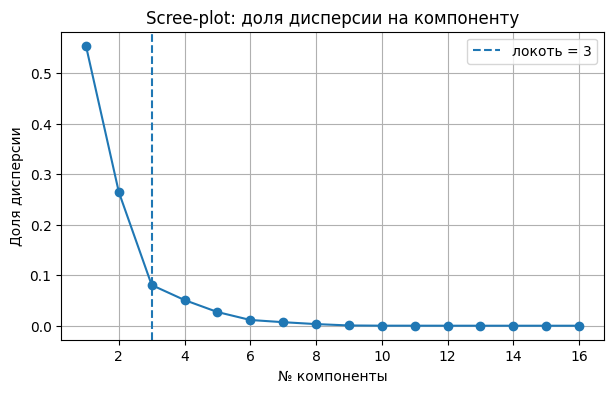

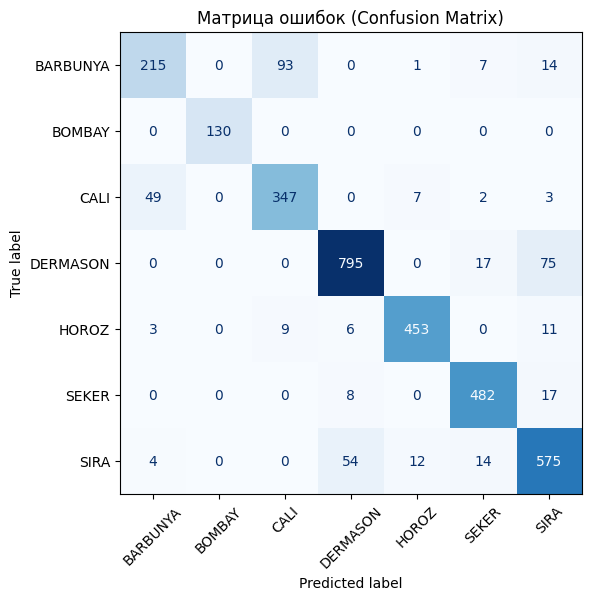

In [ ]:
# =============================================================
# Лаба 10. PCA + "метод локтя" на Dry Bean Dataset
# =============================================================
!pip install kneed

import os, zipfile, urllib.request, io, warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)

from kneed import KneeLocator


url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00602/DryBeanDataset.zip"

print("Скачиваем Dry Bean (~4.5 МБ)...")
response = urllib.request.urlopen(url)
with zipfile.ZipFile(io.BytesIO(response.read())) as z:
    with z.open('DryBeanDataset/Dry_Bean_Dataset.xlsx') as f:
        beans_df = pd.read_excel(f)

print(f"Размер данных: {beans_df.shape}")   # (13611, 17)

# ----------------- 2. Делим и масштабируем -------------------
X = beans_df.drop(columns=['Class']).values
y = beans_df['Class'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# ----------------- 3. Полный PCA -----------------------------
pca_full = PCA().fit(X_train_scaled)
evr = pca_full.explained_variance_ratio_          # доля дисперсии каждой PC

# ----- 3.1. Находим "локоть" методом кривизны ----------------
knee = KneeLocator(
    range(1, len(evr)+1), evr, curve='convex', direction='decreasing')
n_components_knee = knee.knee if knee.knee else len(evr)  # если knee=None

print(f"Число компонент по 'локтю': {n_components_knee}")

# ----------------- 4. Пересчитываем PCA ----------------------
pca = PCA(n_components=n_components_knee, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca  = pca.transform(X_test_scaled)

# ----------------- 5. Обучаем классификатор ------------------
clf = LogisticRegression(max_iter=5000, solver='saga',
                         multi_class='multinomial', n_jobs=-1, random_state=42)
clf.fit(X_train_pca, y_train)

# ----------------- 6. Метрики -------------------------------
y_pred = clf.predict(X_test_pca)
print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}\n")
print("Classification report:\n", classification_report(y_test, y_pred))

# ----------------- 7. Графики -------------------------------
# 7.1 Scree-plot с "локтем"
plt.figure(figsize=(7,4))
plt.plot(range(1, len(evr)+1), evr, marker='o')
plt.axvline(n_components_knee, ls='--', label=f"локоть = {n_components_knee}")
plt.title("Scree-plot: доля дисперсии на компоненту")
plt.xlabel("№ компоненты")
plt.ylabel("Доля дисперсии")
plt.legend(); plt.grid(); plt.show()

# 7.2 Confusion Matrix
cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(cm, display_labels=clf.classes_)
fig, ax = plt.subplots(figsize=(7,6))
disp.plot(cmap='Blues', ax=ax, colorbar=False, xticks_rotation=45)
plt.title("Матрица ошибок (Confusion Matrix)")
plt.show()
